#### QAPP ID: I-CCED-0032994-QP-1-0
#### Author: Matthew Adams
#### Principal Investigator(s): Grace Patlewicz & Imran Shah
#### Last Modified MM DD 2022

### Notebook 0XXX: Multi-Task Learner Implementation


In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import functools
import pandas as pd
import matplotlib.pyplot as plt
import sys
import deepchem as dc
sys.path.append('/home/madams01/march_2023/ml-tox/src')
from mltox.db.mongo import *
from mltox.db.bc import *
from mltox.db.bio import *
from mltox.db.chm import *
import torch
import numpy as np
import random


In [9]:
DB5 = openMongo(db='genra_dev_v5',host='pb.epa.gov',auth=True)


In [10]:
def vote(x):
    votes = list(x)
    if sum(votes)/len(votes) < 0.5:
        return 0
    else:
        return 1

def get_multitask_data(Assay_list):
    dfs = []
    asy_list = []
    for asy in Assay_list:
        try:
            Y1 = get_bio_activities(
                                    DB5.toxcast_fp,
                                    assay=asy,
                                    fld='assay_component_name',
                                    h0='0.7',
                                    val='B1.1',
                                    full=False
                                    )
            Y = Y1.groupby('dsstox_sid').agg(lambda x: vote(x)).reset_index()
            if Y.shape[0] > 0:
                 dfs.append(Y)
                 asy_list.append(asy)
        except:
            pass
    print('loop done')
    df_final = functools.reduce(lambda left,right: pd.merge(left,right,on='dsstox_sid',how='outer'), dfs).fillna(-1)

    cols = [asy for asy in asy_list]
    cols.insert(0,'dsstox_sid')
    Y1 = df_final[cols]

    X1 = get_chm_FP(
                    Y1.dsstox_sid,
                    DB5.chms_fp,
                    fp='mrgn',
                    fill=np.uint(0)
                    )

    SID = set(X1.dsstox_sid.to_list()).intersection(Y1.dsstox_sid)

    XY1 = X1.merge(Y1,on='dsstox_sid',how='right')
    XY1 = XY1[XY1.dsstox_sid.isin(SID)]
    
    X = XY1[X1.columns[X1.columns!='dsstox_sid']]
    Y = XY1[Y1.columns[Y1.columns!='dsstox_sid']]

    return X,Y


In [11]:
if os.path.exists('db_datasets/ATG_x_with_dtx.pkl') and os.path.exists('db_datasets/ATG_y_with_dtx.pkl'):
    print('Existing data file exists.')
    x = pd.read_pickle('db_datasets/ATG_x_with_dtx.pkl').iloc[:,1:-1]
    y = pd.read_pickle('db_datasets/ATG_y_with_dtx.pkl').iloc[:,1:]
else:
    print('Retreiving data from database')
    Assay_list = get_bio_assays(DB5.toxcast_assays)
    prefixes = set([i.split('_')[0] for i in Assay_list])
    subset_assays = [i for i in Assay_list if i.startswith('ATG')]
    x,y= get_multitask_data(subset_assays)

Existing data file exists.


In [12]:
x

,mrgn_0,mrgn_1,mrgn_10,mrgn_100,mrgn_1000,mrgn_1001,mrgn_1002,mrgn_1003,mrgn_1004,mrgn_1005,...,mrgn_990,mrgn_991,mrgn_992,mrgn_993,mrgn_994,mrgn_995,mrgn_996,mrgn_997,mrgn_998,mrgn_999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3763,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Filter/Impute missing Assay label values

In [13]:
random.seed(42)
def assign_missing_values(X,counts):
    p_hit = counts[1] /(counts[0] + counts[1])
    p_nohit = 1 - p_hit
    if X == -1:
         X = random.choices((1,0),weights=[p_hit,p_nohit],k=1)[0]
    return X

def replace_missing_data(y,mode):
    y_new = y.loc[:, ~(y== -1.0).sum()>-y.shape[0]*0.1]   #drop columns with > 10% missing data
    if mode == 'impute':
        for column in y_new:
            if (y_new[column]==-1).any() and not (y_new[column]==-1).all():
                counts = y_new[column].value_counts()
                y_new[column] = y_new[column].apply(lambda x: assign_missing_values(x,counts))
    elif mode == 'fill':
        y_new = y_new.replace(-1,0)
    elif mode == None:
        pass
    return y_new.apply(np.int64)

In [14]:
y_new = replace_missing_data(y,"fill")

y_new

Assay_list = y_new.columns.tolist()

## Visualization of Assay Data 

/home/madams01/anaconda3/envs/tflow_dc_edit/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 55.5, 'ASSAY')

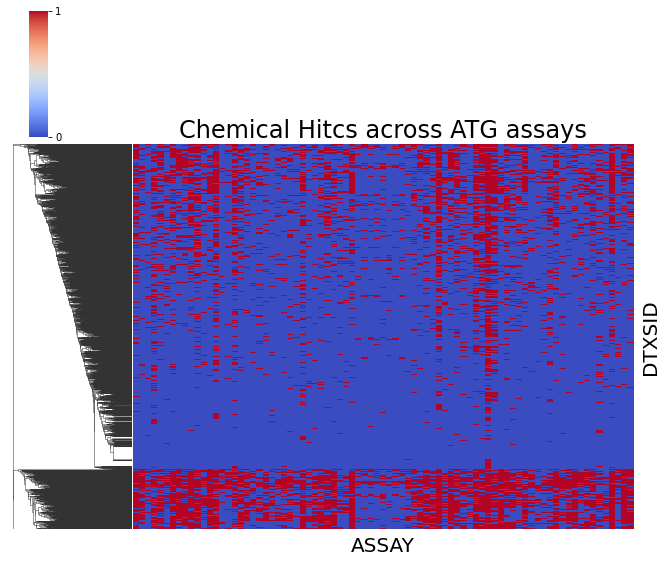

In [15]:
import seaborn as sns
g = sns.clustermap(
        y_new,
        figsize=(9, 7),
        row_cluster=True,
        col_cluster=False,
        xticklabels=False,
        yticklabels=False,
        cmap="coolwarm",
        cbar_pos=(0.05, 0.8, .03, .25),
        cbar_kws={"ticks":[-1,0,1]}
    )

ax = g.ax_heatmap
ax.set_title('Chemical Hitcs across ATG assays',fontsize=24)
ax.set_ylabel('DTXSID',fontsize=20)
ax.set_xlabel('ASSAY',fontsize=20)

In [16]:
import deepchem as dc

tsca_data = pd.read_excel('NCCRP_picklist_round2_refchem_reps.xlsx',sheet_name='Main Data')

unlabeled_data = get_chm_FP(
                tsca_data.DTXSID,
                DB5.chms_fp,
                fp='mrgn',
                fill=np.uint(0)
                    )

N_unlabeled = unlabeled_data.shape[0]

unlabeled_fp = unlabeled_data.iloc[:,1:]

unlabeled_X = pd.concat([x,unlabeled_fp]).fillna(0).tail(N_unlabeled)

Y_tasks = y_new.shape[1]
dummy_labels = np.zeros((N_unlabeled,Y_tasks))

unlabeled_dataset = dc.data.NumpyDataset(X=unlabeled_X, y=dummy_labels)

n_features = unlabeled_X.shape[1]

In [17]:
unlabeled_dataset

<NumpyDataset X.shape: (342, 2048), y.shape: (342, 81), w.shape: (342, 1), ids: [0 1 2 ... 339 340 341], task_names: [ 0  1  2 ... 78 79 80]>

In [18]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
import os


def to_one_hot(X):
    if X >= 0.5:
        return 1
    else:
        return 0


f = np.vectorize(to_one_hot)

dataset = dc.data.NumpyDataset(x,y_new) 
Assay_list = y_new.columns.tolist()
splitter = dc.splits.RandomStratifiedSplitter()

train_dataset, _ ,test_dataset = splitter.train_valid_test_split(dataset,frac_train=0.8,frac_test=0.2,frac_valid=0.0,seed=0,               
                                                        test_dir=f'{os.getcwd()}/tmp_test_data/',
                                                        train_dir=f'{os.getcwd()}/tmp_train_data/',
                                                        valid_dir=f'{os.getcwd()}/tmp_valid_data/')
n_tasks = dataset.y.shape[1]
n_features = dataset.X.shape[1]
model = dc.models.MultitaskClassifier(n_tasks, n_features,layer_sizes=[500],model_dir=f'{os.getcwd()}/tmp_mtl_model/')
model.fit(train_dataset)
y_true = test_dataset.y
y_pred = model.predict(test_dataset)
y_unlabeled_pred = model.predict(unlabeled_dataset)
metric = dc.metrics.roc_auc_score
scores = []
preds = pd.DataFrame()
for i in range(n_tasks):
    score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
    scores.append([Assay_list[i],score])
    preds[Assay_list[i]] = f(y_unlabeled_pred[:,i][:,1])


In [21]:
preds

,ATG_AP_1_CIS,ATG_AP_2_CIS,ATG_AR_TRANS,ATG_Ahr_CIS,ATG_BRE_CIS,ATG_CAR_TRANS,ATG_CMV_CIS,ATG_CRE_CIS,ATG_C_EBP_CIS,ATG_DR4_LXR_CIS,...,ATG_Sp1_CIS,ATG_TAL_CIS,ATG_TA_CIS,ATG_TCF_b_cat_CIS,ATG_TGFb_CIS,ATG_THRa1_TRANS,ATG_VDRE_CIS,ATG_VDR_TRANS,ATG_Xbp1_CIS,ATG_p53_CIS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338,1,0,0,1,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
339,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
340,1,0,0,0,1,0,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0


In [22]:
scores

[['ATG_AP_1_CIS', 0.7161629224779279],
 ['ATG_AP_2_CIS', 0.7132184647955826],
 ['ATG_AR_TRANS', 0.6667123371087564],
 ['ATG_Ahr_CIS', 0.6208180089902813],
 ['ATG_BRE_CIS', 0.6988920147595459],
 ['ATG_CAR_TRANS', 0.6891014492753623],
 ['ATG_CMV_CIS', 0.7581566767613279],
 ['ATG_CRE_CIS', 0.7142774725274725],
 ['ATG_C_EBP_CIS', 0.7239303388345606],
 ['ATG_DR4_LXR_CIS', 0.7710643015521065],
 ['ATG_DR5_RAR_CIS', 0.7096857507795185],
 ['ATG_E2F_CIS', 0.6766042021578649],
 ['ATG_EGR_CIS', 0.7684139531965619],
 ['ATG_ERE_CIS', 0.7154698891441127],
 ['ATG_ERRa_TRANS', 0.7198676835962328],
 ['ATG_ERRg_TRANS', 0.707052948071141],
 ['ATG_ERa_TRANS', 0.7281900524392182],
 ['ATG_E_Box_CIS', 0.682308557813224],
 ['ATG_Ets_CIS', 0.6785858265902611],
 ['ATG_FXR_TRANS', 0.6886641727067259],
 ['ATG_FoxA2_CIS', 0.6661501041259925],
 ['ATG_FoxO_CIS', 0.6533098952493833],
 ['ATG_GAL4_TRANS', 0.656953601953602],
 ['ATG_GATA_CIS', 0.6072147788919942],
 ['ATG_GLI_CIS', 0.6809429824561404],
 ['ATG_GRE_CIS', 0.

## Hyperparameter search


In [15]:
import os
dataset = dc.data.NumpyDataset(x,y_new)

Assay_list = y_new.columns.tolist()
splitter = dc.splits.RandomStratifiedSplitter()
train_dataset,test_dataset,valid_dataset = splitter.train_valid_test_split(dataset,frac_train=0.8,seed=42)

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

params_dict = {
    'n_tasks': [len(Assay_list)],
    'n_features': [2048],
    'layer_sizes': [[500], [1000]],
    'dropouts': [0.5],
    # 'learning_rate': [0.001,0.002],
    # 'weight_decay_penalty_type': ['l2'],
    # 'weight_decay_penalty':[0.01,0.00],
    # 'epochs':[100,200]
}
optimizer = dc.hyper.GridHyperparamOpt(dc.models.MultitaskClassifier)
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
        params_dict, train_dataset, valid_dataset, metric,logdir=f'{os.getcwd()}/tmp_hyperparams/')